In [6]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import curve_fit

# Lecture des données

In [7]:
def lecture(fichier):
    with open(fichier, "r") as f:
        nt = []
        re = []
        im = []
        for line in f:
            data = line.split()
            nt.append(data[0])
            re.append(data[1])
            im.append(data[2])
        nt = nt[1:]
        re = re[1:]
        im = im[1:]
        for i in range(len(nt)):
            nt[i] = float(nt[i])
            re[i] = float(re[i])
            im[i] = float(im[i])
        return nt, re, im

In [8]:
fichier = "./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz8.m-0.3303_m-0.3303.n3.dat"
nt, re, im = lecture(fichier)

In [9]:
#listes par configurations
def par_configs(nt,re,im):
    ntll = [nt[i:i+64] for i in range(0, len(nt),64)]
    rell = [re[i:i+64] for i in range(0, len(re),64)]
    imll = [im[i:i+64] for i in range(0, len(im),64)]
    return ntll, rell, imll

In [10]:
ntll, rell, imll = par_configs(nt,re,im)

In [11]:
#retourne la norme par nt
def normes_par_nt(ntll, rell, imll):
    nont = []
    for i in range(64):
        nonti = []
        for j in range(len(ntll)):
            nonti.append(np.sqrt((rell[j])[i]**2 + (imll[j])[i]**2))
        nont.append(nonti)
    return nont

In [12]:
def re_im_par_nt(rell, imll):
    rent = []
    imnt = []
    for i in range(64):
        renti = []
        imnti = []
        for j in range(len(rell)):
            renti.append(rell[j][i])
            imnti.append(imll[j][i])
        rent.append(renti)
        imnt.append(imnti)
    return rent, imnt

In [13]:
nont = normes_par_nt(ntll, rell, imll)

In [14]:
rent, imnt = re_im_par_nt(rell, imll)

# Premier fit

In [15]:
def moyenne_norme(nont): #renvoie une liste avec les moyennes des normes pour chaque nt, et la liste des erreurs stats associées
    return [np.mean(nont[i]) for i in range(len(nont))], [np.sqrt(np.var(nont[i])) for i in range(len(nont))]

In [16]:
def moyenne_re_im(rent, imnt):
    return [np.mean(rent[i]) for i in range(len(rent))], [np.sqrt(np.var(rent[i])) for i in range(len(rent))], [np.mean(imnt[i]) for i in range(len(imnt))], [np.sqrt(np.var(imnt[i])) for i in range(len(imnt))]

In [17]:
remoy, sigmare, immoy, sigmaim = moyenne_re_im(rent, imnt)

In [18]:
nomoy, sigmaobs = moyenne_norme(nont)
xnt = [i for i in range(64)]

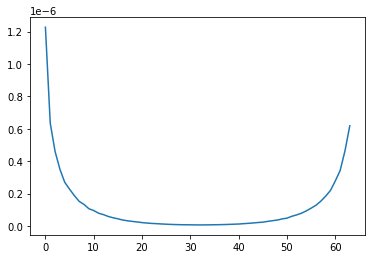

In [19]:
#count,bins  = np.histogram(np.array(immoy)/np.array(remoy))
remoy=np.array(remoy)
plt.plot((nomoy))

Text(0, 0.5, '$ln(C(n_t))$')

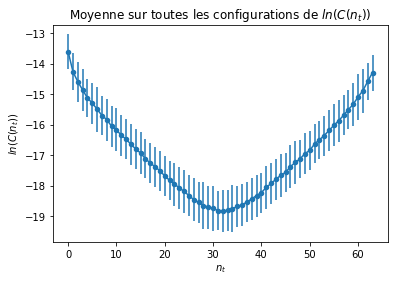

In [20]:
plt.errorbar(xnt,np.log(nomoy), (sigmaobs/np.abs(nomoy)), marker='.', mew=2.5)
plt.title("Moyenne sur toutes les configurations de $ln(C(n_t))$")
plt.xlabel(r"$n_t$")
plt.ylabel(r"$ln(C(n_t))$")

In [21]:
def fit(nt, A0, E0): #la fonction à fit
    return A0*np.cosh((nt-32)*E0)

In [22]:
def estim(inf,sup, nomoy, sigmaobs): #renvoie [A0, E0, chi2, chi2réduit], xdata, ydata, ypred
    xdata = np.array([i for i in range(inf,sup)])
    ydata = np.array(nomoy[inf:sup])
    sigmadata = np.array(sigmaobs[inf:sup])
    popt, pcov = curve_fit(fit, xdata, ydata, sigma = sigmadata)
    A0 = popt[0]
    E0 = popt[1]
    ddl = sup-inf+1-2
    ypred = fit(xdata, A0, E0)
    chi2 = np.sum(((ydata-ypred)/sigmadata)**2)
    chi2red = chi2/ddl
    return [A0, E0, chi2, chi2red], xdata, ydata, ypred, sigmadata

# Effective mass plateau

In [23]:
def plateau(nomoy, sigmaobs):
    chi2 = []
    for i in range(2,31):
        params, xdata, ydata, ypred, sigmadata = estim(31-i, 31+i, nomoy, sigmaobs)
        chi2.append(params[2])
            
    dernier_indice_satisfaisant = -1  # Initialisation avec un indice invalide au cas où aucun élément ne satisfait la condition
    #print(chi2)
    for i, valeur in enumerate(chi2):
        if valeur < 1:
            dernier_indice_satisfaisant = i
    dernier_indice_satisfaisant = dernier_indice_satisfaisant+2
    inf = 31-dernier_indice_satisfaisant
    sup = 31+dernier_indice_satisfaisant
    #print("inf = " + str(inf))
    #print("sup = " + str(sup))
    return inf, sup

In [24]:
inf, sup = plateau(nomoy, sigmaobs)

In [25]:
print(inf, sup)

13 49


On choisit donc comme plateau (13,49) :

In [26]:
params, xdata, ydata, ypred, sigmadata = estim(inf, sup, nomoy, sigmaobs)
print(params[2])

0.022371239783129226


Text(0, 0.5, '$C(n_t)$')

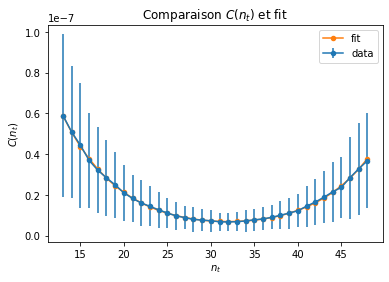

In [27]:
plt.errorbar(xdata, ydata, sigmadata,marker=".", mew=2.5, label="data")
plt.plot(xdata, ypred, marker=".", mew=2.5, label="fit")
plt.title(r"Comparaison $C(n_t)$ et fit")
plt.legend()
plt.xlabel(r"$n_t$")
plt.ylabel(r"$C(n_t)$")

In [28]:
a =  0.0652
x = (1/a)*197.327
E0 = params[1]
Mphysmev = E0*x
print("Masse physique : " + str(Mphysmev) + " MeV")

Masse physique : 451.8517202568747 MeV


# Détermination des erreurs

## Jacknife

In [29]:
nconf = 999
a =  0.0652
x = (1/a)*197.327

In [30]:
def jack(n, nt, re, im): #retourne les listes des nt, re, im par configuration ou il manque la nième configuration
    ntll = [nt[i:i+64] for i in range(0, len(nt),64)]
    rell = [re[i:i+64] for i in range(0, len(re),64)]
    imll = [im[i:i+64] for i in range(0, len(im),64)]
    ntll.pop(n)
    rell.pop(n)
    imll.pop(n)
    return ntll, rell, imll

In [31]:
def jacknife(nconf, fichier, a, x):
    nt, re, im = lecture(fichier)
    E0jn = [] #liste des E0 pour chaque set du jacknife
    
    ntll, rell, imll = par_configs(nt,re,im)
    nont = normes_par_nt(ntll, rell, imll)
    nomoy, sigmaobs = moyenne_norme(nont)
    inf,sup = plateau(nomoy, sigmaobs)
    params, xdata, ydata, ypred, sigmadata = estim(inf, sup, nomoy, sigmaobs)
    
    E0 = params[1] #on trouve E0 sans jacknife d'abord
    
    for n in range(nconf): #on fait le jacknife
        
        ntll, rell, imll = jack(n,nt,re,im)
        
        nont = normes_par_nt(ntll, rell, imll)
        
        nomoy, sigmaobs = moyenne_norme(nont)
        
        inf,sup = plateau(nomoy, sigmaobs)
        
        params, xdata, ydata, ypred, sigmadata = estim(inf, sup, nomoy, sigmaobs)
        
        E0jn.append(params[1])
        
        if (n%100==0): #compteur
            print(n)
            
    E0tild = np.mean(np.array(E0jn))
    biais = (len(E0jn)-1)*(E0tild-E0)
    E0unb = E0 - biais
    sigmajn2 = np.sqrt(np.var(E0jn))
    sigmajn = np.sqrt(((nconf-1)/nconf)*np.sum((np.array(E0jn) - np.ones(nconf)*E0)**2))  #Erreur sur E0 estimée par le jacknife
    
    print("E0 biased= " + str(E0) + " +/- " + str(sigmajn))
    print("M biased = " + str(E0*x) + " +/- " + str(sigmajn*x) + " MeV")
    return E0jn, E0, E0unb, sigmajn
    

In [53]:
E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)

0
100
200
300
400
500
600
700
800
900


biais = 272.96388417018244


E0 tild= 0.14938941488908392 +/- 0.00559427038383917
M tild = 452.12523116285683 +/- 16.930990675334847 MeV


E0 unbiased= 0.05910740503252132 +/- 0.00559427038383917
M unbiased = 178.8878360866923 +/- 16.930990675334847 MeV


E0 biased= 0.14929904250684511 +/- 0.00559427038383917
M biased = 451.8517202568747 +/- 16.930990675334847 MeV


## Bootstrap

In [32]:
def create_set(nt, re, im, nconf):
    ntll = [nt[i:i+64] for i in range(0, len(nt),64)]
    rell = [re[i:i+64] for i in range(0, len(re),64)]
    imll = [im[i:i+64] for i in range(0, len(im),64)]
    conf = [i for i in range(nconf)]
    ind = random.choices(conf,k=nconf)
    ntll = [ntll[i] for i in ind]
    rell = [rell[i] for i in ind]
    imll = [imll[i] for i in ind]
    return ntll, rell, imll

In [33]:
def bootstrap(nbs, nconf, fichier, a, x):
    nt, re, im = lecture(fichier)
    E0bs = []
    
    for n in range(nbs):
        
        ntll, rell, imll = create_set(nt, re, im, nconf)
        
        nont = normes_par_nt(ntll, rell, imll)
        
        nomoy, sigmaobs = moyenne_norme(nont)
        
        inf,sup = plateau(nomoy, sigmaobs)
        
        params, xdata, ydata, ypred, sigmadata = estim(inf, sup, nomoy, sigmaobs)
        
        E0bs.append(params[1])
        
        if (n%100==0): #compteur
            print(n)
    
    E0bstild = np.mean(np.array(E0bs))  #estimator for E0
    sigmabs = np.sqrt(np.var(E0bs)) #error for E0 by bootstrapping
    
    print("\n")
    print("E0 = " + str(E0bstild) + " +/- " + str(sigmabs))
    print("M = " + str(E0bstild*x) + " +/- " + str(sigmabs*x) + " MeV")
    
    return E0bs, E0bstild, sigmabs

In [56]:
nbs = 999
nconf = 999
a =  0.0652
x = (1/a)*197.327

E0bs, E0bstild, sigmabs = bootstrap(nbs, nconf, fichier, a, x)

0
100
200
300
400
500
600
700
800
900


E0 = 0.14937740735035743 +/- 0.0007660801777568956
M = 452.0888904942329 +/- 2.3185322582244625 MeV


Masse trop grande ? Biais trop grand ? Vérifions que le biais diminue lorsque les configurations augmentent

In [48]:
def supprimer_n_conf(nconf, n, nt, re, im): #retourne les listes des nt, re, im ou il manque n configurations
    ntll = [nt[i:i+64] for i in range(0, len(nt),64)]
    rell = [re[i:i+64] for i in range(0, len(re),64)]
    imll = [im[i:i+64] for i in range(0, len(im),64)]
    conf_suppr = random.sample(range(nconf), n)
    ntll = [element for i, element in enumerate(ntll) if i not in conf_suppr]
    rell = [element for i, element in enumerate(rell) if i not in conf_suppr]
    imll = [element for i, element in enumerate(imll) if i not in conf_suppr]
    nt2 = [element for sous_liste in ntll for element in sous_liste]
    re2 = [element for sous_liste in rell for element in sous_liste]
    im2 = [element for sous_liste in imll for element in sous_liste]
    return nt2, re2, im2

In [49]:
with open("pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz8.m-0.3303_m-0.3303.n3.dat", "r") as f:
    nt = []
    re = []
    im = []
    for line in f:
        data = line.split()
        nt.append(data[0])
        re.append(data[1])
        im.append(data[2])
    nt = nt[1:]
    re = re[1:]
    im = im[1:]
    for i in range(len(nt)):
        nt[i] = float(nt[i])
        re[i] = float(re[i])
        im[i] = float(im[i])

In [52]:
biais = []
liste_E0 = []
liste_sig = []
biaisrel = []
nbconfs = []

for i in range(50,999,100):
    nbconfs.append(i)
    nt2,re2,im2 = supprimer_n_conf(nconf, nconf-i, nt, re, im)
    E0jn, E0, E0unb, sigmajn = jacknife(i, fichier, a, x)
    biais.append(E0-E0unb)
    liste_E0.append(E0)
    liste_sig.append(sigmajn)
    biaisrel.append((E0-E0unb)/E0unb)
    print(i)

0


biais = 11.504877507768176


E0 tild= 0.14937662201136243 +/- 0.0010375945627025846
M tild = 452.08651367540057 +/- 3.1402672127977445 MeV


E0 unbiased= 0.14549764678549687 +/- 0.0010375945627025846
M unbiased = 440.34684274910654 +/- 3.1402672127977445 MeV


E0 biased= 0.14929904250684511 +/- 0.0010375945627025846
M biased = 451.8517202568747 +/- 3.1402672127977445 MeV
50
0
100


biais = 38.29366850171209


E0 tild= 0.14938396090384898 +/- 0.002021062359822244
M tild = 452.10872474346337 +/- 6.11672043369086 MeV


E0 unbiased= 0.13664620135326944 +/- 0.002021062359822244
M unbiased = 413.55805175516264 +/- 6.11672043369086 MeV


E0 biased= 0.14929904250684511 +/- 0.002021062359822244
M biased = 451.8517202568747 +/- 6.11672043369086 MeV
150
0
100
200


biais = 66.23853931002073


E0 tild= 0.14938693918903498 +/- 0.00282674424798467
M tild = 452.1177384870354 +/- 8.555106782547103 MeV


E0 unbiased= 0.12741276864156895 +/- 0.00282674424798467
M unbiased = 385.613180946854 +/- 8.55

Text(0, 0.5, 'Biais')

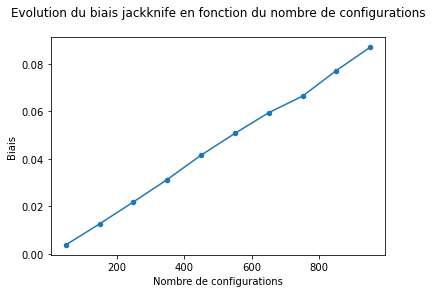

In [53]:
plt.plot(nbconfs, biais,marker=".", mew=2.5)
plt.title("Evolution du biais jackknife en fonction du nombre de configurations"+"\n")
plt.xlabel("Nombre de configurations")
plt.ylabel("Biais")


Text(0, 0.5, 'Masse du pion (MeV)')

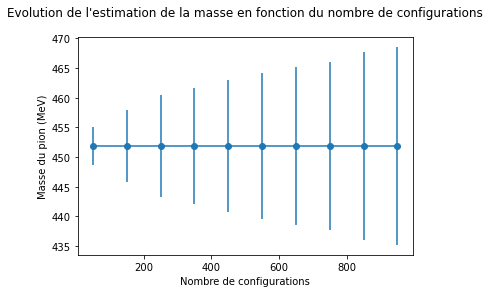

In [54]:
plt.errorbar(nbconfs, np.array(liste_E0)*x, np.array(liste_sig)*x, marker="o")
plt.title("Evolution de l'estimation de la masse en fonction du nombre de configurations"+"\n")
plt.xlabel("Nombre de configurations")
plt.ylabel("Masse du pion (MeV)")

# Courbe d'énergie effective

## pion-g5-S pion-g5-S 

On choisit le jackknife comme méthode de d'estimation des incertitudes. On se penche tout d'abord sur les pion-g5-S pion-g5-S :

On a : $p_i = 2πk_i/(aN)$, $k_i = −N/2+1, . . .,N/2$

In [34]:
a =  0.0652
x = (1/a)*197.327
nconf = 999

In [35]:
list_fichiers = ["./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz"+ str(i) + ".m-0.3303_m-0.3303.n3.dat" for i in range(-8, 9)]
E0_g5S_g5S = []
E0unb_g5S_g5S = []
sigmajn_g5S_g5S = []
for fichier in list_fichiers:
    print("Estimation de l'énergie effective de " + fichier)
    E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)
    E0_g5S_g5S.append(E0)
    E0unb_g5S_g5S.append(E0unb)
    sigmajn_g5S_g5S.append(sigmajn)

Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz-8.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.14929904250684511 +/- 0.00559427038383917
M biased = 451.8517202568747 +/- 16.930990675334847 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz-7.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15043920298055719 +/- 0.010283882354476158
M biased = 455.30240194086525 +/- 31.12404376321652 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz-6.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.1487612127149206 +/- 0.012489543397554235
M biased = 450.2239849907537 +/- 37.79944984676664 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz-5.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15083537215670

C:\Users\yacob\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


100
200
300
400
500
600
700
800
900
E0 biased= 0.15006427243150283 +/- 0.059705498505731466
M biased = 454.16767923452704 +/- 180.69795864479258 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz-2.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.1575122398474331 +/- 0.0009541822158992874
M biased = 476.70886123273675 +/- 2.8878207686619435 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz-1.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.21622865160783167 +/- 0.0008458705433336323
M biased = 654.413360978813 +/- 2.5600168206195657 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz0.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.14752784656346737 +/- 0.00023577285864992824
M biased = 446.49121746670755 +/- 0.7135636637854968 MeV
Estimation de l'énergie effectiv

Text(0.5, 0, '$k$')

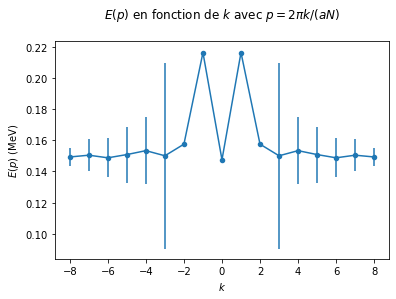

In [39]:
plt.errorbar([i for i in range(-8,9)], np.array(E0_g5S_g5S), np.array(sigmajn_g5S_g5S),marker=".", mew=2.5)
plt.title(r"$E(p)$ en fonction de $k$ avec $p=2 \pi k/ (aN)$"+ "\n")
plt.ylabel(r"$E(p)$ (MeV)")
plt.xlabel(r"$k$")

In [43]:
pi = [(2*np.pi*i)/(16) for i in range(-8,9)]

Text(0.5, 0, '$k$')

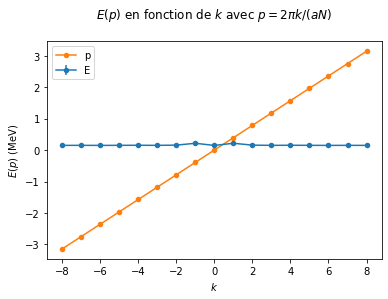

In [45]:
plt.errorbar([i for i in range(-8,9)], np.array(E0_g5S_g5S), np.array(sigmajn_g5S_g5S),marker=".", mew=2.5, label="E")
plt.plot([i for i in range(-8,9)], pi,marker=".", mew=2.5, label = "p")
plt.legend()
plt.title(r"$E(p)$ en fonction de $k$ avec $p=2 \pi k/ (aN)$"+ "\n")
plt.ylabel(r"$E(p)$ (MeV)")
plt.xlabel(r"$k$")

Test $cosh(aE(p)) = cosh(am_H) + (1 − cos(ap_k))$

In [46]:
left_side = np.cosh(np.array(E0_g5S_g5S))

In [47]:
N= 32

In [48]:
cos_ap = np.cos(np.array([(2*np.pi*i)/(N) for i in range(-8, 9)]))

In [49]:
right_side = np.cosh(np.ones(17)*E0_g5S_g5S[8]) + np.ones(17) - cos_ap

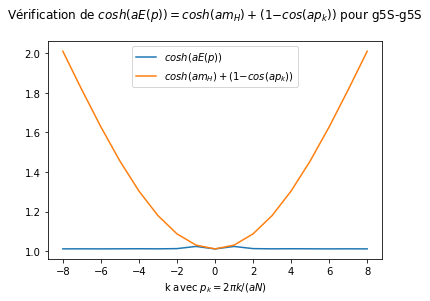

In [51]:
absc = [i for i in range(-8,9)]
plt.plot(absc,left_side, label = r"$cosh(aE(p))$")
plt.plot(absc,right_side, label = r"$cosh(am_H) + (1 − cos(ap_k))$")
plt.title(r"Vérification de $cosh(aE(p)) = cosh(am_H) + (1 − cos(ap_k))$ pour g5S-g5S" + "\n")
plt.xlabel(r"k avec $p_k = 2 \pi k / (aN)$")
plt.legend()

In [143]:
invN = np.arccos(np.ones(8) + np.cosh(np.ones(8)*E0_g5S_g5S[8]) - np.cosh(np.array(E0_g5S_g5S[0:8])))/np.abs(np.array([i for i in range(-8,0)]))

In [148]:
print(np.array([(2*np.pi*i)/(a*N) for i in range(-8, 9)])**2)

[2321.69172746 1777.54522883 1305.95159669  906.91083104  580.42293186
  326.48789917  145.10573297   36.27643324    0.           36.27643324
  145.10573297  326.48789917  580.42293186  906.91083104 1305.95159669
 1777.54522883 2321.69172746]


In [150]:
print((np.array(E0_g5S_g5S)/a)**2)

[ 5.2434708   5.32386282  5.20576104  5.35193964  5.53188129  5.2973592
  5.83624377 10.99844503  5.11979786 10.99844503  5.83624377  5.2973592
  5.53188129  5.35193964  5.20576104  5.32386282  5.2434708 ]


# Vérification du processus d'extraction de l'effective energy

Vérfication du processus d'extraction de l'effective energy pour un fichier au hasard

In [168]:
nt, re, im = lecture("./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz0.m-0.3303_m-0.3303.n3.dat")
ntll, rell, imll = par_configs(nt,re,im)
nont = normes_par_nt(ntll, rell, imll)
remoy, sigmare, immoy, sigmaim = moyenne_re_im(rent, imnt)
nomoy, sigmaobs = moyenne_norme(nont)
xnt = [i for i in range(64)]

Text(0, 0.5, '$ln(C(n_t))$')

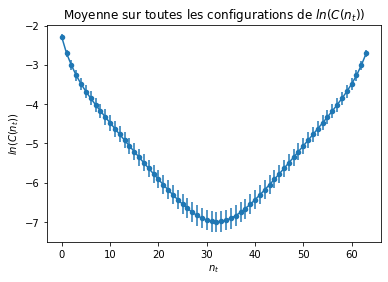

In [169]:
plt.errorbar(xnt,np.log(nomoy), (sigmaobs/np.abs(nomoy)), marker='.', mew=2.5)
plt.title("Moyenne sur toutes les configurations de $ln(C(n_t))$")
plt.xlabel(r"$n_t$")
plt.ylabel(r"$ln(C(n_t))$")

In [170]:
inf, sup = plateau(nomoy, sigmaobs)

In [171]:
print(inf, sup)

4 58


In [172]:
params, xdata, ydata, ypred, sigmadata = estim(inf, sup, nomoy, sigmaobs)
print(params[2])

0.5319428207057885


Text(0, 0.5, '$C(n_t)$')

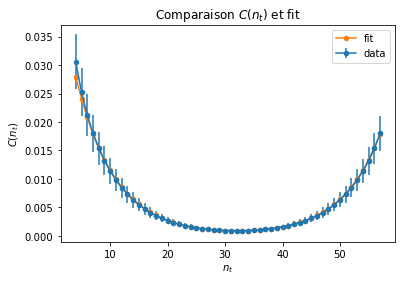

In [173]:
plt.errorbar(xdata, ydata, sigmadata,marker=".", mew=2.5, label="data")
plt.plot(xdata, ypred, marker=".", mew=2.5, label="fit")
plt.title(r"Comparaison $C(n_t)$ et fit")
plt.legend()
plt.xlabel(r"$n_t$")
plt.ylabel(r"$C(n_t)$")

La détermination du plateau et le fit fonctionnent correctement

On va maintenant appliquer ce processus à tous les 8 combinaisons d'opérateurs source/sink disponibles.

## pion-g5-S pion-g5-P

In [174]:
a =  0.0652
x = (1/a)*197.327
nconf = 999

In [175]:
list_fichiers = ["./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz"+ str(i) + ".m-0.3303_m-0.3303.n3.dat" for i in range(-8, 9)]
E0_g5S_g5P = []
E0unb_g5S_g5P = []
sigmajn_g5S_g5P = []
for fichier in list_fichiers:
    print("Estimation de l'énergie effective de " + fichier)
    E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)
    E0_g5S_g5P.append(E0)
    E0unb_g5S_g5P.append(E0unb)
    sigmajn_g5S_g5P.append(sigmajn)

Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-8.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500


C:\Users\yacob\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


600
700
800
900
E0 biased= 0.15356576187767854 +/- 0.03728429504602477
M biased = 464.76489408031716 +/- 112.84046148078114 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-7.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.1554157335975643 +/- 0.04299244911772537
M biased = 470.3638107915119 +/- 130.11611974008275 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-6.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.1534588156289081 +/- 0.05745424832868967
M biased = 464.4412225706373 +/- 173.88457760667714 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-5.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15341528467235016 +/- 0.054048100903147614
M biased = 464.3094766647369 +/- 163.57591421649403 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,

Text(0.5, 0, '$k$')

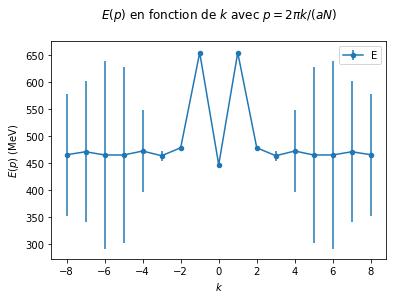

In [176]:
plt.errorbar([i for i in range(-8,9)], np.array(E0_g5S_g5P)*x, np.array(sigmajn_g5S_g5P)*x,marker=".", mew=2.5, label="E")
#plt.plot([i for i in range(-8,9)], pi,marker=".", mew=2.5, label = "p")
plt.legend()
plt.title(r"$E(p)$ en fonction de $k$ avec $p=2 \pi k/ (aN)$"+ "\n")
plt.ylabel(r"$E(p)$ (MeV)")
plt.xlabel(r"$k$")

## pion-g45-S pion-g45-S

In [180]:
a =  0.0652
x = (1/a)*197.327
nconf = 999

In [181]:
list_fichiers = ["./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz"+ str(i) + ".m-0.3303_m-0.3303.n3.dat" for i in range(-8, 9)]
E0_g45S_g45S = []
E0unb_g45S_g45S = []
sigmajn_g45S_g45S = []
for fichier in list_fichiers:
    print("Estimation de l'énergie effective de " + fichier)
    E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)
    E0_g45S_g45S.append(E0)
    E0unb_g45S_g45S.append(E0unb)
    sigmajn_g45S_g45S.append(sigmajn)

Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz-8.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15327631020251867 +/- 0.012594577312538744
M biased = 463.8888721370001 +/- 38.117333701707565 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz-7.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.1538324806967042 +/- 0.01016954145951547
M biased = 465.57211531347474 +/- 30.777992447573766 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz-6.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15300408509236518 +/- 0.011940831516870962
M biased = 463.064986181306 +/- 36.138780072539824 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz-5.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15312

Text(0.5, 0, '$k$')

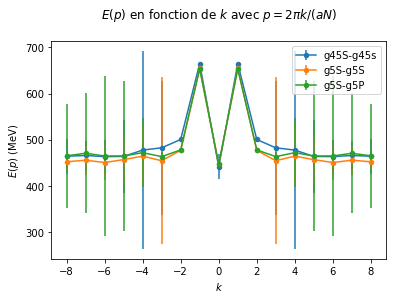

In [183]:
plt.errorbar([i for i in range(-8,9)], np.array(E0_g45S_g45S)*x, np.array(sigmajn_g45S_g45S)*x,marker=".", mew=2.5, label="g45S-g45s")
plt.errorbar([i for i in range(-8,9)], np.array(E0_g5S_g5S)*x, np.array(sigmajn_g5S_g5S)*x,marker=".", mew=2.5, label="g5S-g5S")
plt.errorbar([i for i in range(-8,9)], np.array(E0_g5S_g5P)*x, np.array(sigmajn_g5S_g5P)*x,marker=".", mew=2.5, label="g5S-g5P")
#plt.plot([i for i in range(-8,9)], pi,marker=".", mew=2.5, label = "p")
plt.legend()
plt.title(r"$E(p)$ en fonction de $k$ avec $p=2 \pi k/ (aN)$"+ "\n")
plt.ylabel(r"$E(p)$ (MeV)")
plt.xlabel(r"$k$")

## pion-g45-S pion-g45-P

In [184]:
a =  0.0652
x = (1/a)*197.327
nconf = 999

In [185]:
list_fichiers = ["./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz"+ str(i) + ".m-0.3303_m-0.3303.n3.dat" for i in range(-8, 9)]
E0_g45S_g45P = []
E0unb_g45S_g45P = []
sigmajn_g45S_g45P = []
for fichier in list_fichiers:
    print("Estimation de l'énergie effective de " + fichier)
    E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)
    E0_g45S_g45P.append(E0)
    E0unb_g45S_g45P.append(E0unb)
    sigmajn_g45S_g45P.append(sigmajn)

Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz-8.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.16158251243770247 +/- 0.033457344195057484
M biased = 489.027491285192 +/- 101.25824168678082 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz-7.m-0.3303_m-0.3303.n3.dat
0
100
200
300


C:\Users\yacob\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


400
500
600
700
800
900
E0 biased= 0.16019922278105175 +/- 0.046990829958157544
M biased = 484.8409821122179 +/- 142.21717029376313 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz-6.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.16044410812195134 +/- 0.03628677510864327
M biased = 485.58212459172233 +/- 109.82147962980447 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz-5.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15931872532945288 +/- 0.05233325526289069
M biased = 482.17616737860357 +/- 158.38595492730727 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz-4.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.16136996993054506 +/- 0.021473272396536867
M biased = 488.38423399516364 +/- 64.98859543238392 MeV
Estimation de l'énergie effective de ./dat

Text(0.5, 0, '$k$')

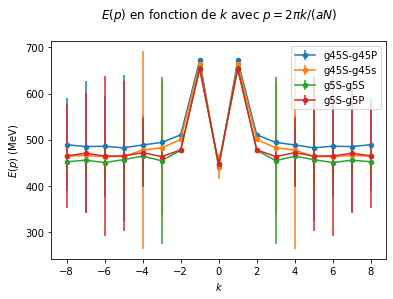

In [195]:
plt.errorbar([i for i in range(-8,9)], np.array(E0_g45S_g45P)*x, np.array(sigmajn_g45S_g45P)*x,marker=".", mew=2.5, label="g45S-g45P")
plt.errorbar([i for i in range(-8,9)], np.array(E0_g45S_g45S)*x, np.array(sigmajn_g45S_g45S)*x,marker=".", mew=2.5, label="g45S-g45s")
plt.errorbar([i for i in range(-8,9)], np.array(E0_g5S_g5S)*x, np.array(sigmajn_g5S_g5S)*x,marker=".", mew=2.5, label="g5S-g5S")
plt.errorbar([i for i in range(-8,9)], np.array(E0_g5S_g5P)*x, np.array(sigmajn_g5S_g5P)*x,marker=".", mew=2.5, label="g5S-g5P")
#plt.plot([i for i in range(-8,9)], pi,marker=".", mew=2.5, label = "p")
plt.legend()
plt.title(r"$E(p)$ en fonction de $k$ avec $p=2 \pi k/ (aN)$"+ "\n")
plt.ylabel(r"$E(p)$ (MeV)")
plt.xlabel(r"$k$")

## pion-g45-S pion-g5-S

In [3]:
a =  0.0652
x = (1/a)*197.327
nconf = 999

In [189]:
list_fichiers = ["./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz"+ str(i) + ".m-0.3303_m-0.3303.n3.dat" for i in range(-8, 9)]
E0_g45S_g5S = []
E0unb_g45S_g5S = []
sigmajn_g45S_g5S = []
for fichier in list_fichiers:
    print("Estimation de l'énergie effective de " + fichier)
    E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)
    E0_g45S_g5S.append(E0)
    E0unb_g45S_g5S.append(E0unb)
    sigmajn_g45S_g5S.append(sigmajn)

Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz-8.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15727590759781554 +/- 0.016978040634907397
M biased = 475.9936045790514 +/- 51.38383166203025 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz-7.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15490405320302394 +/- 0.00737152673860084
M biased = 468.81521635572255 +/- 22.309835226194604 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz-6.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.1572158542302827 +/- 0.010811089660468065
M biased = 475.8118537990644 +/- 32.71963020599973 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz-5.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.1563230997

Text(0.5, 0, '$k$')

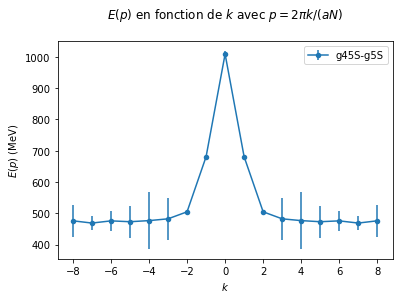

In [190]:
plt.errorbar([i for i in range(-8,9)], np.array(E0_g45S_g5S)*x, np.array(sigmajn_g45S_g5S)*x,marker=".", mew=2.5, label="g45S-g5S")
#plt.plot([i for i in range(-8,9)], pi,marker=".", mew=2.5, label = "p")
plt.legend()
plt.title(r"$E(p)$ en fonction de $k$ avec $p=2 \pi k/ (aN)$"+ "\n")
plt.ylabel(r"$E(p)$ (MeV)")
plt.xlabel(r"$k$")

## pion-g45-S pion-g5-P

In [191]:
list_fichiers = ["./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz"+ str(i) + ".m-0.3303_m-0.3303.n3.dat" for i in range(-8, 9)]
E0_g45S_g5P = []
E0unb_g45S_g5P = []
sigmajn_g45S_g5P = []
for fichier in list_fichiers:
    print("Estimation de l'énergie effective de " + fichier)
    E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)
    E0_g45S_g5P.append(E0)
    E0unb_g45S_g5P.append(E0unb)
    sigmajn_g45S_g5P.append(sigmajn)

Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-8.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.16484763950693523 +/- 0.05432133380261219
M biased = 498.9093582973162 +/- 164.40285023417266 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-7.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.16277037403098302 +/- 0.05819316609110457
M biased = 492.62253982226673 +/- 176.1209031481502 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-6.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.1639262326888807 +/- 0.0361058116961287
M biased = 496.1207318680793 +/- 109.27379608223909 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-5.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800


C:\Users\yacob\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


900
E0 biased= 0.1616340497830884 +/- 0.07001815808395202
M biased = 489.18346842864247 +/- 211.90909632257674 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-4.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.16512135811267922 +/- 0.06916852921802073
M biased = 499.73776429908986 +/- 209.33770498472975 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-3.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.16648667755512747 +/- 0.027482678331872602
M biased = 503.8698868392737 +/- 83.17598876063536 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-2.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.1690041162728828 +/- 0.0010322350936308412
M biased = 511.4888842297416 +/- 3.12404684541247 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,

Text(0.5, 0, '$k$')

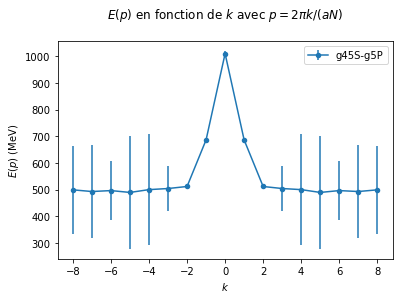

In [192]:
plt.errorbar([i for i in range(-8,9)], np.array(E0_g45S_g5P)*x, np.array(sigmajn_g45S_g5P)*x,marker=".", mew=2.5, label="g45S-g5P")
#plt.plot([i for i in range(-8,9)], pi,marker=".", mew=2.5, label = "p")
plt.legend()
plt.title(r"$E(p)$ en fonction de $k$ avec $p=2 \pi k/ (aN)$"+ "\n")
plt.ylabel(r"$E(p)$ (MeV)")
plt.xlabel(r"$k$")

## pion-g5-S pion-g45-S

In [193]:
list_fichiers = ["./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz"+ str(i) + ".m-0.3303_m-0.3303.n3.dat" for i in range(-8, 9)]
E0_g5S_g45S = []
E0unb_g5S_g45S = []
sigmajn_g5S_g45S = []
for fichier in list_fichiers:
    print("Estimation de l'énergie effective de " + fichier)
    E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)
    E0_g5S_g45S.append(E0)
    E0unb_g5S_g45S.append(E0unb)
    sigmajn_g5S_g45S.append(sigmajn)

Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz-8.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15174059508799193 +/- 0.00749084549447106
M biased = 459.2410491860152 +/- 22.670951976802012 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz-7.m-0.3303_m-0.3303.n3.dat
0
100


C:\Users\yacob\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


200
300
400
500
600
700
800
900
E0 biased= 0.1514129284402821 +/- 0.005172899665083178
M biased = 458.249370097171 +/- 15.655717365212706 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz-6.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15038033992061767 +/- 0.007127924459433021
M biased = 455.1242536122044 +/- 21.572575917278222 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz-5.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15161408658711736 +/- 0.012925721915495868
M biased = 458.8581727603698 +/- 39.119538779433334 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz-4.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.153344448420903 +/- 0.013167986709190862
M biased = 464.09509161888855 +/- 39.85275020497708 MeV
Estimation de l'énergie effective de ./da

Text(0.5, 0, '$k$')

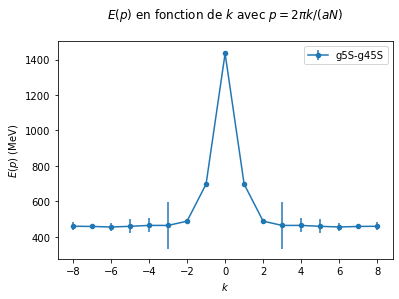

In [197]:
plt.errorbar([i for i in range(-8,9)], np.array(E0_g5S_g45S)*x, np.array(sigmajn_g5S_g45S)*x,marker=".", mew=2.5, label="g5S-g45S")
#plt.plot([i for i in range(-8,9)], pi,marker=".", mew=2.5, label = "p")
plt.legend()
plt.title(r"$E(p)$ en fonction de $k$ avec $p=2 \pi k/ (aN)$"+ "\n")
plt.ylabel(r"$E(p)$ (MeV)")
plt.xlabel(r"$k$")

## pion-g5-S pion-g45-P

In [196]:
list_fichiers = ["./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz"+ str(i) + ".m-0.3303_m-0.3303.n3.dat" for i in range(-8, 9)]
E0_g5S_g45P = []
E0unb_g5S_g45P = []
sigmajn_g5S_g45P = []
for fichier in list_fichiers:
    print("Estimation de l'énergie effective de " + fichier)
    E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)
    E0_g5S_g45P.append(E0)
    E0unb_g5S_g45P.append(E0unb)
    sigmajn_g5S_g45P.append(sigmajn)

Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz-8.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15261468285831642 +/- 0.034577876935691906
M biased = 461.8864650978989 +/- 104.64952027744292 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz-7.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15407562055179064 +/- 0.04929966808349786
M biased = 466.30797510158277 +/- 149.20484055080343 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz-6.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15355220078667628 +/- 0.04150482202776347
M biased = 464.72385160479257 +/- 125.61383460540618 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz-5.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.1530517

Text(0.5, 0, '$k$')

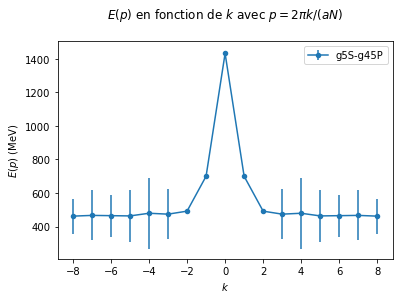

In [198]:
plt.errorbar([i for i in range(-8,9)], np.array(E0_g5S_g45P)*x, np.array(sigmajn_g5S_g45P)*x,marker=".", mew=2.5, label="g5S-g45P")
#plt.plot([i for i in range(-8,9)], pi,marker=".", mew=2.5, label = "p")
plt.legend()
plt.title(r"$E(p)$ en fonction de $k$ avec $p=2 \pi k/ (aN)$"+ "\n")
plt.ylabel(r"$E(p)$ (MeV)")
plt.xlabel(r"$k$")

In [201]:
donnees_g5S_g5S = np.array(list(zip(E0_g5S_g5S, E0unb_g5S_g5S, sigmajn_g5S_g5S)))
np.savetxt('g5S_g5S.dat', donnees_g5S_g5S, fmt='%.20f', delimiter='\t')
donnees_g5S_g5P = np.array(list(zip(E0_g5S_g5P, E0unb_g5S_g5P, sigmajn_g5S_g5P)))
np.savetxt('g5S_g5P.dat', donnees_g5S_g5P, fmt='%.20f', delimiter='\t')
donnees_g5S_g45S = np.array(list(zip(E0_g5S_g45S, E0unb_g5S_g45S, sigmajn_g5S_g45S)))
np.savetxt('g5S_g45S.dat', donnees_g5S_g45S, fmt='%.20f', delimiter='\t')
donnees_g5S_g45P = np.array(list(zip(E0_g5S_g45P, E0unb_g5S_g45P, sigmajn_g5S_g45P)))
np.savetxt('g5S_g45P.dat', donnees_g5S_g45P, fmt='%.20f', delimiter='\t')
donnees_g45S_g5S = np.array(list(zip(E0_g45S_g5S, E0unb_g45S_g5S, sigmajn_g45S_g5S)))
np.savetxt('g45S_g5S.dat', donnees_g45S_g5S, fmt='%.20f', delimiter='\t')
donnees_g45S_g5P = np.array(list(zip(E0_g45S_g5P, E0unb_g45S_g5P, sigmajn_g45S_g5P)))
np.savetxt('g45S_g5P.dat', donnees_g45S_g5P, fmt='%.20f', delimiter='\t')
donnees_g45S_g45S = np.array(list(zip(E0_g45S_g45S, E0unb_g45S_g45S, sigmajn_g45S_g45S)))
np.savetxt('g45S_g45S.dat', donnees_g45S_g45S, fmt='%.20f', delimiter='\t')
donnees_g45S_g45P = np.array(list(zip(E0_g45S_g45P, E0unb_g45S_g45P, sigmajn_g45S_g45P)))
np.savetxt('g45S_g45P.dat', donnees_g45S_g45P, fmt='%.20f', delimiter='\t')